<a href="https://colab.research.google.com/github/gobi2001-2006/satellite-image-classsification-using-resnet-18-and-SVM/blob/main/ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

# Upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gobikacom","key":"c0be6fc84012f31d8450ab6b4ea1d4fa"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions

In [ ]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip
!unzip EuroSAT.zip -d eurosat_data


Streaming output truncated to the last 5000 lines.
  inflating: eurosat_data/2750/SeaLake/SeaLake_2206.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_1313.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_263.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_967.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_515.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_1465.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_1817.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_2902.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_2570.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_1004.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_174.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_2111.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_2388.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_1948.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_838.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_2738.jpg  
  inflating: eurosat_data/

In [ ]:
import os

# Set dataset path
dataset_path = 'eurosat_data/2750'

# List classes and count images
classes = sorted(os.listdir(dataset_path))
print("📊 Classes in EuroSAT Dataset:\n")
for cls in classes:
    cls_path = os.path.join(dataset_path, cls)
    if os.path.isdir(cls_path):
        num_images = len(os.listdir(cls_path))
        print(f"🔹 {cls}: {num_images} images")


📊 Classes in EuroSAT Dataset:

🔹 AnnualCrop: 3000 images
🔹 Forest: 3000 images
🔹 HerbaceousVegetation: 3000 images
🔹 Highway: 2500 images
🔹 Industrial: 2500 images
🔹 Pasture: 2000 images
🔹 PermanentCrop: 2500 images
🔹 Residential: 3000 images
🔹 River: 2500 images
🔹 SeaLake: 3000 images


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


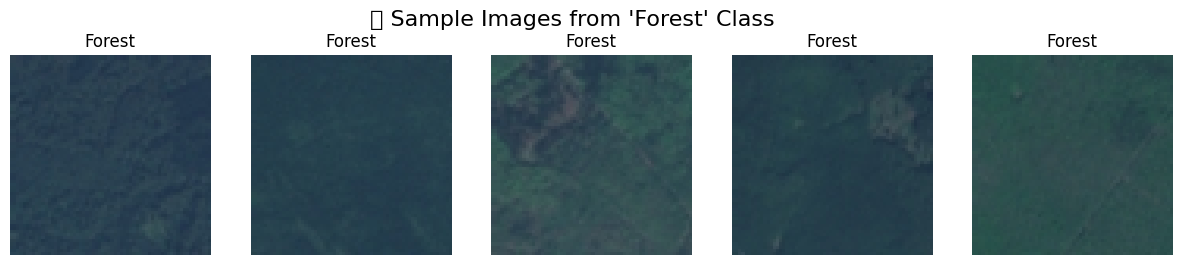

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Pick random class
sample_class = random.choice(classes)
sample_path = os.path.join(dataset_path, sample_class)
sample_images = random.sample(os.listdir(sample_path), 5)

# Plot images
plt.figure(figsize=(15, 3))
for i, img_file in enumerate(sample_images):
    img_path = os.path.join(sample_path, img_file)
    image = mpimg.imread(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(sample_class)
plt.suptitle(f"🔍 Sample Images from '{sample_class}' Class", fontsize=16)
plt.show()


In [ ]:
!pip install scikit-image


In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Path to dataset
dataset_path = 'eurosat_data/2750'

# Feature extraction function
def extract_features(img_path):
    try:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (64, 64))  # Normalize size

        # HOG
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hog_features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), block_norm='L2-Hys', feature_vector=True)

        # Color Histogram
        chans = cv2.split(img)
        hist_features = []
        for chan in chans:
            hist = cv2.calcHist([chan], [0], None, [32], [0, 256])
            hist = cv2.normalize(hist, hist).flatten()
            hist_features.extend(hist)

        # Combine features
        return np.hstack([hog_features, hist_features])
    except:
        return None

# Loop through dataset and extract features
X = []
y = []
class_names = sorted(os.listdir(dataset_path))

print("🔍 Extracting features from all images...")
for label in tqdm(class_names):
    class_path = os.path.join(dataset_path, label)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            features = extract_features(img_path)
            if features is not None:
                X.append(features)
                y.append(label)

# Convert to arrays
X = np.array(X)
y = LabelEncoder().fit_transform(y)

print(f"\n✅ Feature extraction complete! Total samples: {len(X)}, Feature size: {X.shape[1]}")


🔍 Extracting features from all images...


100%|██████████| 10/10 [01:21<00:00,  8.12s/it]


✅ Feature extraction complete! Total samples: 27000, Feature size: 1860


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train SVM
svm = SVC(kernel='linear', C=1.0)
svm.fit(X_train, y_train)

# Predict
y_pred = svm.predict(X_test)

# Results
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))


✅ Accuracy: 0.8072222222222222

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.81      0.79       595
           1       0.94      0.97      0.95       606
           2       0.68      0.76      0.72       602
           3       0.65      0.65      0.65       515
           4       0.88      0.87      0.88       493
           5       0.81      0.78      0.80       423
           6       0.67      0.62      0.64       473
           7       0.90      0.89      0.89       597
           8       0.72      0.66      0.69       490
           9       0.98      0.98      0.98       606

    accuracy                           0.81      5400
   macro avg       0.80      0.80      0.80      5400
weighted avg       0.81      0.81      0.81      5400



In [ ]:
import joblib

import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# Path to your dataset
DATASET_DIR = "eurosat_data/2750"

# Get class labels (folder names)
class_labels = os.listdir(DATASET_DIR)
class_labels.sort()

# Initialize data and labels
features = []
labels = []

# Feature extraction function
def extract_features(image):
    image = cv2.resize(image, (64, 64))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # HOG features
    hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=False)

    # Color histogram (RGB)
    chans = cv2.split(image)
    hist_features = []
    for chan in chans:
        hist = cv2.calcHist([chan], [0], None, [32], [0, 256])
        hist_features.extend(hist.flatten())

    return np.hstack([hog_feat, hist_features])

# Extract features from dataset
for label in tqdm(class_labels, desc="🔍 Extracting features from all images"):
    class_path = os.path.join(DATASET_DIR, label)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        image = cv2.imread(img_path)
        if image is not None:
            feat = extract_features(image)
            features.append(feat)
            labels.append(label)

# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels_encoded)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train SVM model
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

# Accuracy on test set
y_pred = svm.predict(X_test)
print("✅ Test Accuracy:", accuracy_score(y_test, y_pred))

# Predict function for new image
def extract_features_from_path(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (64, 64))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # HOG
    hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=False)

    # Color Histogram
    chans = cv2.split(image)
    hist_features = []
    for chan in chans:
        hist = cv2.calcHist([chan], [0], None, [32], [0, 256])
        hist_features.extend(hist.flatten())

    features = np.hstack([hog_feat, hist_features])
    return features.reshape(1, -1), cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

joblib.dump((svm, scaler, le), "svm_model_with_scaler_and_encoder_compressed.joblib", compress=('xz', 3))


🔍 Extracting features from all images: 100%|██████████| 10/10 [01:02<00:00,  6.20s/it]


✅ Test Accuracy: 0.7561111111111111


['svm_model_with_scaler_and_encoder_compressed.joblib']

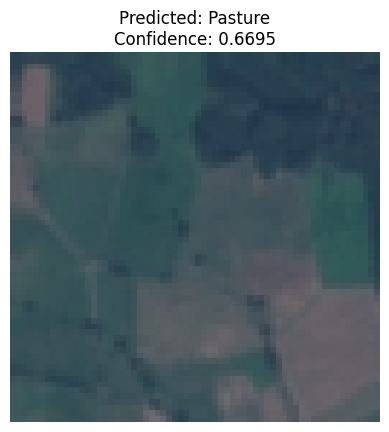

🧠 Predicted Class: Pasture
🎯 Prediction Confidence: 0.6695


In [ ]:
# Predict and visualize
def predict_image(image_path, svm_model=svm):
    features_scaled, image_rgb = extract_features_from_path(image_path)
    features_scaled = scaler.transform(features_scaled)

    pred_label_idx = svm_model.predict(features_scaled)[0]
    confidence = np.max(svm_model.predict_proba(features_scaled))
    pred_label = le.inverse_transform([pred_label_idx])[0]

    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title(f"Predicted: {pred_label}\nConfidence: {confidence:.4f}")
    plt.show()

    print(f"🧠 Predicted Class: {pred_label}")
    print(f"🎯 Prediction Confidence: {confidence:.4f}")

# Run test

predict_image("pas.jpg")